In [1]:
import cv2
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt

In [2]:
import numpy as np 
import os
import tensorflow as tf
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from tensorflow.keras.losses import BinaryCrossentropy
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model



2023-04-24 19:02:55.598806: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred[0])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [4]:
def loss_fn(y_true, y_pred):
    # y_pred = tf.expand_dims(y_pred, axis=-1)
    # print(y_pred.shape)
    # print(y_true.shape)
    # loss0 = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred[0], pos_weight=2, name=None)
    # loss1 = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred[1], pos_weight=2, name=None)
    # loss2 = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred[2], pos_weight=2, name=None)
    # loss3 = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred[3], pos_weight=2, name=None)
    # loss4 = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred[4], pos_weight=2, name=None)
    # loss5 = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred[5], pos_weight=2, name=None)
    # loss6 = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred[6], pos_weight=2, name=None)

    loss0 = bce(y_true, y_pred[0])
    loss1 = bce(y_true, y_pred[1])
    loss2 = bce(y_true, y_pred[2])
    loss3 = bce(y_true, y_pred[3])
    loss4 = bce(y_true, y_pred[4])
    loss5 = bce(y_true, y_pred[5])
    loss6 = bce(y_true, y_pred[6])
    return loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6

def REBNCONV(x, out_ch=3, dirate=1):
    #x = ZeroPadding2D((1*dirate,1*dirate))(x)
    x = Conv2D(out_ch, 3, padding='same', dilation_rate = 1*dirate)(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    return x

def _upsample_like(src, tar):
    h = int(tar.shape[1]/src.shape[1])
    w = int(tar.shape[2]/src.shape[2])
    src = UpSampling2D((h,w), interpolation='bilinear')(src)
    return src

def RSU7(x, mid_ch=12, out_ch=3):
    
    x0 = REBNCONV(x, out_ch, 1)
    
    x1 = REBNCONV(x0, mid_ch, 1)
    x = MaxPool2D(2, 2)(x1)

    x2 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x2)

    x3 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x3)

    x4 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x4)

    x5 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x5)

    x6 = REBNCONV(x, mid_ch, 1)

    x = REBNCONV(x6, mid_ch, 2)

    x = REBNCONV(tf.concat([x,x6],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x5)

    x = REBNCONV(tf.concat([x,x5],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x4)

    x = REBNCONV(tf.concat([x,x4],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x3)

    x = REBNCONV(tf.concat([x,x3],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x2)

    x = REBNCONV(tf.concat([x,x2],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x1)

    x = REBNCONV(tf.concat([x,x1],axis=-1), out_ch, 1)

    return x + x0

def RSU6(x, mid_ch=12, out_ch=3):
    
    x0 = REBNCONV(x, out_ch, 1)
    
    x1 = REBNCONV(x0, mid_ch, 1)
    x = MaxPool2D(2, 2)(x1)

    x2 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x2)

    x3 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x3)

    x4 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x4)

    x5 = REBNCONV(x, mid_ch, 1)

    x = REBNCONV(x, mid_ch, 2)

    x = REBNCONV(tf.concat([x,x5],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x4)

    x = REBNCONV(tf.concat([x,x4],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x3)

    x = REBNCONV(tf.concat([x,x3],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x2)

    x = REBNCONV(tf.concat([x,x2],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x1)

    x = REBNCONV(tf.concat([x,x1],axis=-1), out_ch, 1)

    return x + x0

def RSU5(x, mid_ch=12, out_ch=3):
    
    x0 = REBNCONV(x, out_ch, 1)
    
    x1 = REBNCONV(x0, mid_ch, 1)
    x = MaxPool2D(2, 2)(x1)

    x2 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x2)

    x3 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x3)

    x4 = REBNCONV(x, mid_ch, 1)

    x = REBNCONV(x, mid_ch, 2)

    x = REBNCONV(tf.concat([x,x4],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x3)

    x = REBNCONV(tf.concat([x,x3],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x2)

    x = REBNCONV(tf.concat([x,x2],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x1)

    x = REBNCONV(tf.concat([x,x1],axis=-1), out_ch, 1)

    return x + x0

def RSU4(x, mid_ch=12, out_ch=3):
    
    x0 = REBNCONV(x, out_ch, 1)
    
    x1 = REBNCONV(x0, mid_ch, 1)
    x = MaxPool2D(2, 2)(x1)

    x2 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x2)

    x3 = REBNCONV(x, mid_ch, 1)

    x = REBNCONV(x, mid_ch, 2)

    x = REBNCONV(tf.concat([x,x3],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x2)

    x = REBNCONV(tf.concat([x,x2],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x1)

    x = REBNCONV(tf.concat([x,x1],axis=-1), out_ch, 1)

    return x + x0

def RSU4F(x, mid_ch=12, out_ch=3):

    x0 = REBNCONV(x, out_ch, 1)
    
    x1 = REBNCONV(x0, mid_ch, 1)
    x2 = REBNCONV(x1, mid_ch, 2)
    x3 = REBNCONV(x2, mid_ch, 4)
    
    x4 = REBNCONV(x3, mid_ch, 8)
    
    x = REBNCONV(tf.concat([x4,x3],axis=-1), mid_ch, 4)
    x = REBNCONV(tf.concat([x,x2],axis=-1), mid_ch, 2)
    x = REBNCONV(tf.concat([x,x1],axis=-1), out_ch, 1)

    return x + x0

def U2NET(x, out_ch=1):
    
    x1 = RSU7(x, 32, 64)
    x = MaxPool2D(2, 2)(x1)

    x2 = RSU6(x, 32, 128)
    x = MaxPool2D(2, 2)(x2)

    x3 = RSU5(x, 64, 256)
    x = MaxPool2D(2, 2)(x3)

    x4 = RSU4(x, 128, 512)
    x = MaxPool2D(2, 2)(x4)

    x5 = RSU4F(x, 256, 512)
    x = MaxPool2D(2, 2)(x5)

    x6 = RSU4F(x, 256, 512)
    x = _upsample_like(x6,x5)

    #-----------------decoder--------------------#

    x5 = RSU4F(tf.concat([x,x5],axis=-1),256, 512)
    x = _upsample_like(x5,x4)

    x4 = RSU4(tf.concat([x,x4],axis=-1),128, 256)
    x = _upsample_like(x4,x3)

    x3 = RSU5(tf.concat([x,x3],axis=-1),64, 128)
    x = _upsample_like(x3,x2)

    x2 = RSU6(tf.concat([x,x2],axis=-1),32, 64)
    x = _upsample_like(x2,x1)
    
    x1 = RSU7(tf.concat([x,x1],axis=-1),16, 64)

    #Side output
    x = ZeroPadding2D((1,1))(x1) 
    d1 = Conv2D(out_ch, 3)(x)
    d1 = Activation('sigmoid')(d1)

    x = ZeroPadding2D((1,1))(x2) 
    x = Conv2D(out_ch, 3)(x)
    d2 = _upsample_like(x,d1)
    d2 = Activation('sigmoid')(d2)
    
    x = ZeroPadding2D((1,1))(x3) 
    x = Conv2D(out_ch, 3)(x)
    d3 = _upsample_like(x,d1)
    d3 = Activation('sigmoid')(d3)
    
    x = ZeroPadding2D((1,1))(x4) 
    x = Conv2D(out_ch, 3)(x)
    d4 = _upsample_like(x,d1)
    d4 = Activation('sigmoid')(d4)
    
    x = ZeroPadding2D((1,1))(x5) 
    x = Conv2D(out_ch, 3)(x)
    d5 = _upsample_like(x,d1)
    d5 = Activation('sigmoid')(d5)
    
    x = ZeroPadding2D((1,1))(x6) 
    x = Conv2D(out_ch, 3)(x)
    d6 = _upsample_like(x,d1)
    d6 = Activation('sigmoid')(d6)

    d0 = Conv2D(out_ch, 1)(tf.concat([d1,d2,d3,d4,d5,d6],axis=-1))
    d0 = Activation('sigmoid')(d0)

    return tf.stack([d0,d1,d2,d3,d4,d5,d6])

def U2NETP(x, out_ch=1):
    
    x1 = RSU7(x, 16, 64)
    x = MaxPool2D(2, 2)(x1)

    x2 = RSU6(x, 16, 64)
    x = MaxPool2D(2, 2)(x2)

    x3 = RSU5(x, 16, 64)
    x = MaxPool2D(2, 2)(x3)

    x4 = RSU4(x, 16, 64)
    x = MaxPool2D(2, 2)(x4)

    x5 = RSU4F(x, 16, 64)
    x = MaxPool2D(2, 2)(x5)

    x6 = RSU4F(x, 16, 64)
    x = _upsample_like(x6,x5)

    #---------------decoder--------------------
    x5 = RSU4F(tf.concat([x,x5],axis=-1),16, 64)
    x = _upsample_like(x5,x4)

    x4 = RSU4(tf.concat([x,x4],axis=-1),16, 64)
    x = _upsample_like(x4,x3)

    x3 = RSU5(tf.concat([x,x3],axis=-1),16, 64)
    x = _upsample_like(x3,x2)

    x2 = RSU6(tf.concat([x,x2],axis=-1),16, 64)
    x = _upsample_like(x2,x1)
    
    x1 = RSU7(tf.concat([x,x1],axis=-1),16, 64)

    x = ZeroPadding2D((1,1))(x1) 
    d1 = Conv2D(out_ch, 3)(x)
    d1 = Activation('sigmoid')(d1)

    x = ZeroPadding2D((1,1))(x2) 
    x = Conv2D(out_ch, 3)(x)
    d2 = _upsample_like(x,d1)
    d2 = Activation('sigmoid')(d2)
    
    x = ZeroPadding2D((1,1))(x3) 
    x = Conv2D(out_ch, 3)(x)
    d3 = _upsample_like(x,d1)
    d3 = Activation('sigmoid')(d3)
    
    x = ZeroPadding2D((1,1))(x4) 
    x = Conv2D(out_ch, 3)(x)
    d4 = _upsample_like(x,d1)
    d4 = Activation('sigmoid')(d4)
    
    x = ZeroPadding2D((1,1))(x5) 
    x = Conv2D(out_ch, 3)(x)
    d5 = _upsample_like(x,d1)
    d5 = Activation('sigmoid')(d5)
    
    x = ZeroPadding2D((1,1))(x6) 
    x = Conv2D(out_ch, 3)(x)
    d6 = _upsample_like(x,d1)
    d6 = Activation('sigmoid')(d6)

    d0 = Conv2D(out_ch, 1)(tf.concat([d1,d2,d3,d4,d5,d6],axis=-1))
    d0 = Activation('sigmoid')(d0)

    return tf.stack([d0,d1,d2,d3,d4,d5,d6]) 

net_input = Input(shape=(512,512,1)) 

model_output = U2NETP(net_input)

model2 = Model(inputs = net_input, outputs = model_output)

lr = 1e-3

opt = tf.keras.optimizers.Adam(learning_rate = lr)

bce = BinaryCrossentropy()

model2.compile(optimizer = opt, loss = loss_fn, metrics = [dice_coef])


2023-04-24 19:03:07.847867: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 2s 2s/step


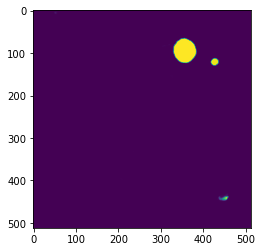

In [129]:
img = cv2.imread('rectified_data/test/images/thm_dir_N00_120_0_30_120_150522.png',0)
preds = model2.predict(img.reshape((1,512,512,1))/255)
plt.imshow(preds[0].reshape((512,512)))
plt.show()

In [77]:
# (os.listdir('rectified_data/test/images/'))

In [5]:
model2.load_weights('modelunet_512_shuffle_combine_1.h5')
img_data = []
pred_pad2 = []
true_mask = []
for files in sorted(os.listdir('rectified_data/test/images/')):
    if(files[-3:]=='png'):
        img = cv2.imread('rectified_data/test/images/'+files,0)
        preds = model2.predict(img.reshape((1,512,512,1))/255)
        img_data.append(img)
        pred_pad2.append(preds[0].reshape((512,512)))
        truth = cv2.imread('rectified_data/test/mask/'+files,0)
        true_mask.append(truth)
        # break

1/1 [==============================] - 2s 2s/step


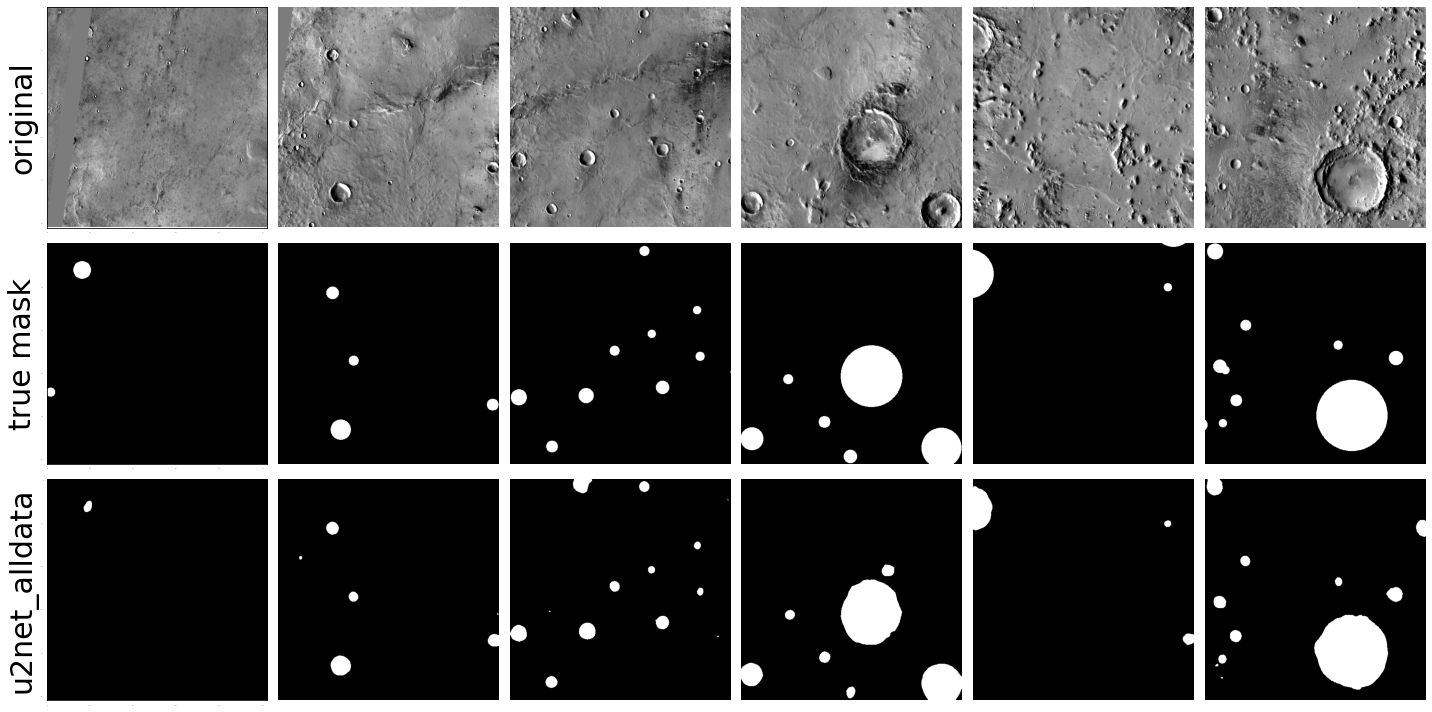

In [28]:
# Plot some random training examples from each dataset

import matplotlib.pyplot as plt
import numpy as np
# Set the random seed
np.random.seed(0)

n = 6

fig, axes = plt.subplots(ncols=n, nrows=3, figsize=(20,10))
for i in range(0,n):
    # rand = np.random.randint(0, mnist_x_train.shape[0])
    axes[0,i].imshow(img_data[i+68], cmap='gray')
    if(i==0):
        axes[0,i].set_ylabel('original',fontsize=30)
        axes[0,i].tick_params(axis='both', labelsize=0, length = 0)
    else:
        axes[0,i].axis('off')
    
    
    axes[1,i].imshow(true_mask[i+68], cmap='gray')
    if(i==0):
        axes[1,i].set_ylabel('true mask',fontsize=30)
        axes[1,i].tick_params(axis='both', labelsize=0, length = 0)
    else:
        axes[1,i].axis('off')
        
    axes[2,i].imshow(np.where(pred_pad2[i+68]>0.7, 1, 0).astype(np.float32), cmap='gray')
    if(i==0):
        axes[2,i].set_ylabel('u2net_alldata',fontsize=30)
        axes[2,i].tick_params(axis='both', labelsize=0, length = 0)
    else:
        axes[2,i].axis('off')
        
   
    
fig.tight_layout()
fig.savefig('foo.png')

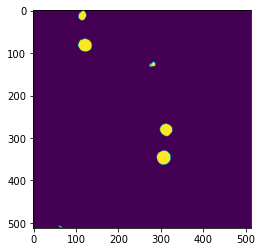

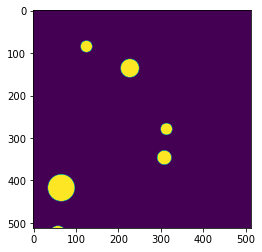

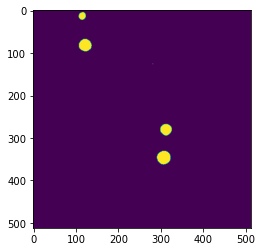

In [224]:
# print(np.unique(np.where(pred_pad2[0]>0.6, 1, 0)))
plt.imshow(np.where(pred_pad2[3]>0.1, 1, 0).astype(np.float32))
plt.show()
plt.imshow(true_mask[3].astype(np.float32))
plt.show()
plt.imshow(np.where(pred_pad2[3]>0.65, 1, 0).astype(np.float32))
plt.show()

In [ ]:
pred_pad

In [124]:
len(pred_pad2)

225

In [225]:
def create_tile(img_list):
    step = 512
    newpx = 512
    px = 7680
    count = 0
    tile = np.zeros((7680,7680))
    for y in range(0,px,step): #no need to sub 512 b/c px are mult of 512
        for x in range(0,px,step):
            # print(x,y)
            temp_img = np.where(img_list[count]>0.65, 1, 0).astype(np.float32)
            tile[x:x+newpx,y:y+newpx] = temp_img*255
            count += 1
            # count += 1
            # break
    cv2.imwrite('u2net_pad_dice_tile_reconstructed_new_combine_1thresh.png',tile)
    return tile

In [226]:
tile = create_tile(pred_pad2)

In [166]:
tile = cv2.imread('unet_pad_dice_tile_reconstructed_512960combine_1.png',0)

In [167]:
# import match_utils

In [230]:
def crater_list_to_image(crater_array,img, img_size=2048):
    craters_found_img = img
    for i in range(len(crater_array)):
        x_ctr = crater_array[i][0]; y_ctr = crater_array[i][1]; r=crater_array[i][2]
        brightness = 255; thick = 4
        #cv2.circle(img, center, radius, color, thickness=1, lineType=8, shift=0)
        cv2.circle(img=craters_found_img,center=(x_ctr,y_ctr),radius=r,color= (0,255,0), thickness=4) 
        #print(x_ctr)
    
    plt.gcf().set_size_inches((12,12))
    plt.imshow(craters_found_img)
    plt.show()
    return craters_found_img

In [231]:
def template_match_t(target, minrad=7.9, maxrad=138.2,
                     longlat_thresh2=longlat_thresh2_, rad_thresh=rad_thresh_,
                     template_thresh=template_thresh_,
                     target_thresh=target_thresh_, rw=8):
        """Extracts crater coordinates (in pixels) from a CNN-predicted target by
        iteratively sliding rings through the image via match_template from
        scikit-image.
        Parameters
        ----------
        target : array
            CNN-predicted target.
        minrad : integer
            Minimum ring radius to search target over.
        maxrad : integer
            Maximum ring radius to search target over.
        longlat_thresh2 : float
            Minimum squared longitude/latitude difference between craters to be
            considered distinct detections.
        rad_thresh : float
            Minimum fractional radius difference between craters to be considered
            distinct detections.
        template_thresh : float
            Minimum match_template correlation coefficient to count as a detected
            crater.
        target_thresh : float
            Value between 0-1. All pixels > target_thresh are set to 1, and
            otherwise set to 0.
        Returns
        -------
        coords : array
            Pixel coordinates of successfully detected craters in predicted target.
        """

        # thickness of rings for template match
        #commented out because this is passed now
        #rw = 8 #default 2 from DeepMoon project, we use 8 or 4

        # threshold target
        target[target >= target_thresh] = 1
        target[target < target_thresh] = 0
        rw = -1

        radii = np.arange(minrad, maxrad + 1, 1, dtype=int)
        coords = []     # coordinates extracted from template matching
        corr = []       # correlation coefficient for coordinates set
        for r in radii:
            # template
            n = 2 * (r + rw + 1)
            template = np.zeros((n, n))
            cv2.circle(template, (r + rw + 1, r + rw + 1), r, 1, rw)

            # template match - result is nxn array of probabilities
            result = match_template(target, template, pad_input=True)
            index_r = np.where(result > template_thresh)
            coords_r = np.asarray(list(zip(*index_r)))
            corr_r = np.asarray(result[index_r])

            # store x,y,r
            if len(coords_r) > 0:
                for c in coords_r:
                    coords.append([c[1], c[0], r])
                for l in corr_r:
                    corr.append(np.abs(l))

        # remove duplicates from template matching at neighboring radii/locations
        coords, corr = np.asarray(coords), np.asarray(corr)
        i, N = 0, len(coords)
        while i < N:
            Long, Lat, Rad = coords.T
            lo, la, r = coords[i]
            minr = np.minimum(r, Rad)

            dL = ((Long - lo)**2 + (Lat - la)**2) / minr**2
            dR = abs(Rad - r) / minr
            index = (dR < rad_thresh) & (dL < longlat_thresh2)
            if len(np.where(index == True)[0]) > 1:
                # replace current coord with max match probability coord in
                # duplicate list
                coords_i = coords[np.where(index == True)]
                corr_i = corr[np.where(index == True)]
                coords[i] = coords_i[corr_i == np.max(corr_i)][0]
                index[i] = False
                coords = coords[np.where(index == False)]
            N, i = len(coords), i + 1

        return coords

In [232]:
from skimage.feature import match_template

longlat_thresh2_ = 1.8
rad_thresh_ = 1.0
template_thresh_ = 0.5
target_thresh_ = 0.1
minr_px=7.9
maxr_px=138.2
# targ_thresh=0.4
rw = -1

In [ ]:
tile_crater_coords_combine_thresh = template_match_t(tile, minrad=minr_px, maxrad=maxr_px,
                 longlat_thresh2=longlat_thresh2_, rad_thresh=rad_thresh_,
                 template_thresh=template_thresh_,
                 target_thresh=targ_thresh, rw=rw)

In [ ]:
og_img = cv2.imread('Robbins_Dataset/out/thm_dir_N00_120_0_30_120_150_filled.png')

In [173]:
# tile_crater_coords

In [ ]:
tile_found = crater_list_to_image(tile_crater_coords_combine_thresh,og_img, img_size=7680)

In [163]:
with open(r'tile_crater_coords_shuffle_combine.txt', 'w') as fp:
    for item in tile_crater_coords_combine:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


In [99]:
cv2.imwrite('u2net_pad_dice_tile_template_new_model_edges.png',tile_found)

True

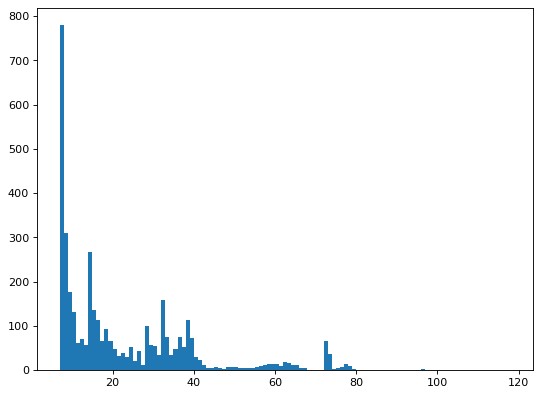

In [149]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.hist(tile_crater_coords[:,2],bins=np.arange(tile_crater_coords[:,2].min(),tile_crater_coords[:,2].max()+1))
plt.show()

In [74]:
print(np.max(tile_crater_coords[:,2]))
np.min(tile_crater_coords[:,2])

118


7

In [123]:
import pandas as pd
tile_csv = pd.read_csv('Robbins_Dataset/csv_tiles/CSV_Tile_16_0_30_120_150_px.csv')

In [124]:
tile_csv_px = tile_csv.iloc[:,3:6]
# print(tile_csv_px)

tile_csv_px_xyr = np.copy(tile_csv_px) #making a copy isn't strictly necessary

#switch order of first two cols of new array from y-x-rad to x-y-rad
tile_csv_px_xyr[:,[0, 1, 2]] = tile_csv_px_xyr[:,[1, 0, 2]]
tile_csv_px_xyr

array([[1389, 7211,  359],
       [2622, 5459,  236],
       [ 472, 6965,  219],
       ...,
       [5106,  798,    3],
       [4573, 4004,    3],
       [7555,  123,    3]])

In [125]:
def template_match_t2c( target, csv_coords, templ_coords=None, minrad=7, maxrad=140,
                           longlat_thresh2=longlat_thresh2_,
                           rad_thresh=rad_thresh_, template_thresh=template_thresh_,
                           target_thresh=target_thresh_, rw=-1, rmv_oor_csvs=0):
        """Extracts crater coordinates (in pixels) from a CNN-predicted target and
        compares the resulting detections to the corresponding human-counted crater
        data.
        Parameters
        ----------
        target : array
            CNN-predicted target.
        csv_coords : array
            Human-counted crater coordinates (in pixel units).
        minrad : integer
            Minimum ring radius to search target over.
        maxrad : integer
            Maximum ring radius to search target over.
        longlat_thresh2 : float
            Minimum squared longitude/latitude difference between craters to be
            considered distinct detections.
        rad_thresh : float
            Minimum fractional radius difference between craters to be considered
            distinct detections.
        template_thresh : float
            Minimum match_template correlation coefficient to count as a detected
            crater.
        target_thresh : float
            Value between 0-1. All pixels > target_thresh are set to 1, and
            otherwise set to 0.
        rmv_oor_csvs : boolean, flag
            If set to 1, remove craters from the csv that are outside your
            detectable range.
        Returns
        -------
        N_match : int
            Number of crater matches between your target and csv.
        N_csv : int
            Number of csv entries
        N_detect : int
            Total number of detected craters from target.
        maxr : int
            Radius of largest crater extracted from target.
        err_lo : float
            Mean longitude error between detected craters and csvs.
        err_la : float
            Mean latitude error between detected craters and csvs.
        err_r : float
            Mean radius error between detected craters and csvs.
        frac_dupes : float
            Fraction of craters with multiple csv matches.
        """
        # get coordinates from template matching IF they are not passed
        if(templ_coords is None):
            templ_coords = template_match_t(target, minrad, maxrad, longlat_thresh2,
                                        rad_thresh, template_thresh, target_thresh, rw)
        else:
            print('Found craters: ' + str(len(templ_coords)))
            # self.logger.info('Found craters: ' + str(len(templ_coords)))

        # find max detected crater radius
        maxr = 0
        if len(templ_coords > 0):
            maxr = np.max(templ_coords.T[2])

        # compare template-matched results to ground truth csv input data
        N_match = 0
        frac_dupes = 0
        err_lo, err_la, err_r = 0, 0, 0
        N_csv, N_detect = len(csv_coords), len(templ_coords)
        for lo, la, r in templ_coords:
            Long, Lat, Rad = csv_coords.T
            minr = np.minimum(r, Rad)

            dL = ((Long - lo)**2 + (Lat - la)**2) / minr**2
            dR = abs(Rad - r) / minr
            index = (dR < rad_thresh) & (dL < longlat_thresh2)
            index_True = np.where(index == True)[0]
            N = len(index_True)
            if N >= 1:
                Lo, La, R = csv_coords[index_True[0]].T
                meanr = (R + r) / 2.
                err_lo += abs(Lo - lo) / meanr
                err_la += abs(La - la) / meanr
                err_r += abs(R - r) / meanr
                if N > 1: # duplicate entries hurt recall
                    frac_dupes += (N-1) / float(len(templ_coords))
            N_match += min(1, N)
            # remove csv(s) so it can't be re-matched again
            csv_coords = csv_coords[np.where(index == False)]
            if len(csv_coords) == 0:
                break

        if rmv_oor_csvs == 1:
            upper = 15
            lower = minrad_
            N_large_unmatched = len(np.where((csv_coords.T[2] > upper) |
                                             (csv_coords.T[2] < lower))[0])
            if N_large_unmatched < N_csv:
                N_csv -= N_large_unmatched

        if N_match >= 1:
            err_lo = err_lo / N_match
            err_la = err_la / N_match
            err_r = err_r / N_match

        stats = [N_match, N_csv, N_detect, maxr]
        #self.logger.info('N_match')
        err = [err_lo, err_la, err_r]
        return stats, err, frac_dupes, templ_coords

In [176]:
stats, err, frac_dupes, templ_coords = template_match_t2c(tile, 
                    tile_csv_px_xyr, templ_coords=tile_crater_coords_combine, 
                    minrad=minr_px, maxrad=maxr_px, 
                    longlat_thresh2=longlat_thresh2_, rad_thresh=rad_thresh_, 
                    template_thresh=template_thresh_, target_thresh=targ_thresh, 
                    rw=-1, rmv_oor_csvs=0)

Found craters: 2454


In [177]:
print(stats, err, frac_dupes)

[683, 6881, 2454, 137] [0.1846740437036395, 0.16478030163465812, 0.22973867061522588] 0.0028524857375713123


In [178]:
def make_comparison_plot(img_fn, coords, csv_px_xyr, rpx_min=7.9, rpx_max=138.2, save_fn=None, SAVE=True, SHOW=False):
    #load grayscale image, cv2 loads as color by default
    #img = np.zeros((7680,7680,3), np.uint8) #start with black, color image
    img = cv2.imread(img_fn) #default loads as color image even though grayscale

    #make a copy of the numpy arrays
    crater_array = np.copy(coords)
    from_csv = np.copy(csv_px_xyr)

    #Add All the Annotation Craters
    counter = 0 #counter will be the number of craters within the px range
    for i in range(len(from_csv)):
        x_ctr = from_csv[i][0]; y_ctr = from_csv[i][1]; r=from_csv[i][2]
        brightness = 255; thick = 8
        #cv2.circle(img, center, radius, color, thickness=1, lineType=8, shift=0)
        if(r<rpx_max and r>rpx_min):
            #annotation craters in blue
            cv2.circle(img,(x_ctr,y_ctr), r, (0,0,255), thick) #blue
            counter=counter+1
    print(counter)

    for i in range(len(crater_array)): #found craters
        x_ctr = crater_array[i][0]; y_ctr = crater_array[i][1]; r=crater_array[i][2]
        brightness = 255; thick = 8
        #cv2.circle(img, center, radius, color, thickness=1, lineType=8, shift=0)
        #found craters in green
        cv2.circle(img,(x_ctr,y_ctr), r, (0,255,0), int(thick/2)) #green

    #if (SAVE is True and save_fn is not None):
    #    print('Saving file at: ' + save_fn + '.png')
    #    cv2.imwrite(save_fn + '.png', img) #GIANT file >100 MB
    
    if(SHOW or SAVE):
        plt.imshow(img)
        plt.gcf().set_size_inches((12,12))
        plt.xticks([]), plt.yticks([])
        if (SAVE):
            plt.savefig('tempge' + '.png')
        if (SHOW):
            plt.show()

        plt.imshow(img[0:2048,0:2048,:])
        plt.gcf().set_size_inches((12,12))
        plt.xticks([]), plt.yticks([])
        #plt.savefig(save_fn + '_zoom' + '.png')
        #plt.show()
        if (SAVE):
            plt.savefig('tempge' + '_zoom' + '.png')
        if (SHOW):
            plt.show()
        
    return counter

776


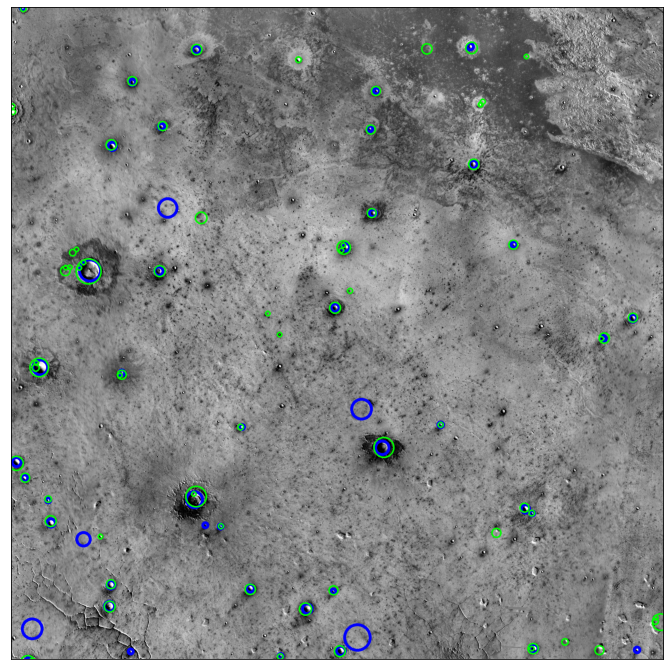

In [179]:
range_c = make_comparison_plot('Robbins_Dataset/out/thm_dir_N00_120_0_30_120_150_filled.png',tile_crater_coords_combine,tile_csv_px_xyr)

In [180]:
str(stats[0]/range_c)

'0.8801546391752577'

In [94]:
import json
score = []
with open('tile_crater_coords_shuffle.txt') as f:
    for line in f:
        score.append((line.strip()))
        # print(score)
    # print(lines)

In [95]:
for i,x in enumerate(score):
    score[i] = [int(y) for y in x[1:-1].split(' ') if y.strip()]

In [96]:
# import ast
# _array = [(int(y) if y.strip() else None) for y in score[1:-1].split(',')]
# # fruits
# print(score[0][1])

In [97]:
# print(score)

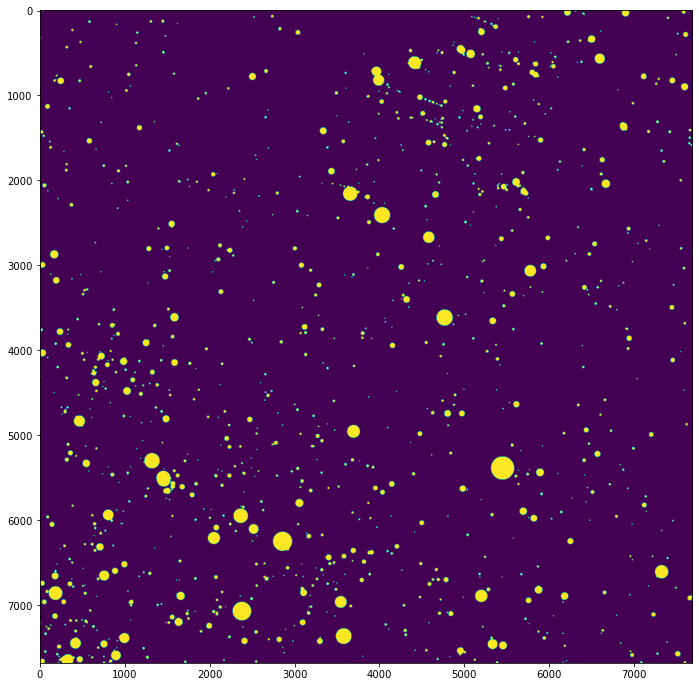

In [183]:
import matplotlib.pyplot as plt
gt_craters = np.zeros((7680,7680))
gt_craters = crater_list_to_image(tile_crater_coords_combine,gt_craters)

In [92]:
np.unique(gt_craters)

array([0.])

In [18]:
import numpy as np
import cv2
k=1

# segmentation
seg = cv2.imread('ntemp_img_c.png',0)
# seg = seg[seg>0]
# seg[30:70, 30:70] = k
seg[seg >= 0.7] = 1
seg[seg < 0.5] = 0

# ground truth
gt = cv2.imread('Robbins_Dataset/out/thm_dir_N00_270_0_30_-90_-60_2_32_km_segrng.png',0)
# gt[30:70, 40:80] = k
gt[gt >= 0.1] = 1
gt[gt < 0.1] = 0

dice = np.sum(seg[gt==k])*2.0 / (np.sum(seg) + np.sum(gt))

print ('Dice similarity score is {}'.format(dice))

Dice similarity score is 0.5971657023522596


In [16]:
import numpy as np
import cv2
k=1

# segmentation
seg = gt_craters
# seg[30:70, 30:70] = k
seg[seg >= 0.1] = 1
seg[seg < 0.1] = 0

# ground truth
gt = cv2.imread('Robbins_Dataset/out/thm_dir_N00_120_0_30_120_150_2_32_km_segrng.png',0)
# gt[30:70, 40:80] = k
gt[gt >= 0.1] = 1
gt[gt < 0.1] = 0

dice = np.sum(seg[gt==k])*2.0 / (np.sum(seg) + np.sum(gt))

print ('Dice similarity score is {}'.format(dice))

NameError: name 'gt_craters' is not defined